In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
from scipy import interpolate

plt.rcParams.update({'font.size': 14})

from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi

from utilities import GS,smoothing, restriction, residual,prolongation

In [23]:
# The name of variable ends with c and f are corse and fine mesh
start = time.time()
Nx1 = 161
Ny1 = 161
Nx2 = 101
Ny2 = 101
Nx3 = 11
Ny3 = 11
L = 1  # length
H = 1  # length

phi1 = np.zeros((Nx1, Ny1))
phi2 = np.zeros((Nx2, Ny2))
phi3 = np.zeros((Nx3, Ny3))

dx1 = L / (Nx1 - 1)  # Grid size
dy1 = L / (Ny1 - 1)  # Grid size
x1_list = np.arange(0, 1 + dx1, dx1)
y1_list = np.arange(0, 1 + dy1, dy1)
x1, y1 = np.meshgrid(x1_list, y1_list, indexing='ij')

dx2 = L / (Nx2 - 1)  # Grid size
dy2 = L / (Ny2 - 1)  # Grid size
x2_list = np.arange(0, 1 + dx2, dx2)
y2_list = np.arange(0, 1 + dy2, dy2)
x2, y2 = np.meshgrid(x2_list, y2_list, indexing='ij')

dx3 = L / (Nx3 - 1)  # Grid size
dy3 = L / (Ny3 - 1)  # Grid size
x3_list = np.arange(0, 1 + dx3, dx3)
y3_list = np.arange(0, 1 + dy3, dy3)
x3, y3 = np.meshgrid(x3_list, y3_list, indexing='ij')

tolf = 1e-6
tolc = 1e-1

aE1 = 1 / dx1 ** 2
aW1 = 1 / dx1 ** 2
aN1 = 1 / dy1 ** 2
aS1 = 1 / dy1 ** 2
a01 = -(2 / dx1 ** 2 + 2 / dy1 ** 2)

aE2 = 1 / dx2 ** 2
aW2 = 1 / dx2 ** 2
aN2 = 1 / dy2 ** 2
aS2 = 1 / dy2 ** 2
a02 = -(2 / dx2 ** 2 + 2 / dy2 ** 2)

aE3 = 1 / dx3 ** 2
aW3 = 1 / dx3 ** 2
aN3 = 1 / dy3 ** 2
aS3 = 1 / dy3 ** 2
a03 = -(2 / dx3 ** 2 + 2 / dy3 ** 2)

phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
R2_1_old, _, _ = residual(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01, convert=False)


In [24]:
for l in tqdm(range(10000)):
    # Smoothing
    R2_1, R_1_new = smoothing(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01)

    # Resitriction on 2nd grid
    phi2, R2_2, R_2_new = restriction(Nx2, Ny2, R_1_new, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list,multi_sweep=10)

    # Resitriction on 3rd grid
    phi3, R2_3, R_3_new = restriction(Nx3, Ny3, R_2_new, aE3, aW3, aE3, aS3, a03, x2_list, y2_list, x3_list, y3_list,multi_sweep=20)

    phi2 = prolongation(x3_list, y3_list, phi3, x2_list, y2_list, phi2)

    phi1 = prolongation(x2_list, y2_list, phi2, x1_list, y1_list, phi1)

    if l % 20 == 0:
        clear_output(True)
        print('Residual on Fine mesh:', R2_1, 'Residual on Coarse mesh:', R2_2)

    if R2_1 < tolf:
        print('Converged! Residual: ', R2_1, 'Time elapsed: ', time.time() - start)
        break

  1%|          | 81/10000 [00:15<34:49,  4.75it/s]

Residual on Fine mesh: 1.0915397079229785e-06 Residual on Coarse mesh: 4.2637844053730713e-07


  1%|          | 81/10000 [00:16<32:42,  5.05it/s]

Converged! Residual:  8.426506533807564e-07 Time elapsed:  34.09216618537903


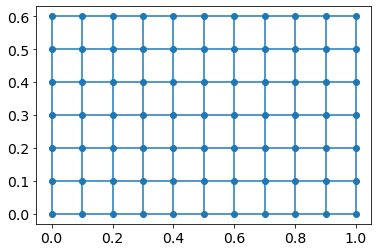

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

x, y = np.meshgrid(np.linspace(0,1, 11), np.linspace(0, 0.6, 7))

plt.scatter(x, y)

segs1 = np.stack((x,y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(segs2))
plt.show()

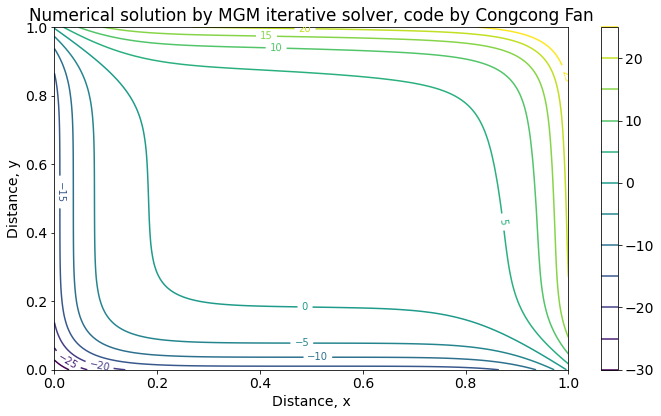

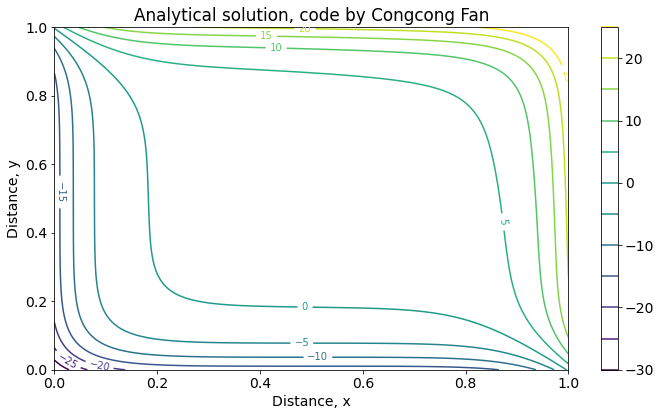

In [20]:

# Analytical solution
x = np.linspace(0,1,Nx1)
y = np.linspace(0,1,Ny1)
phi_A = np.zeros((Nx1,Ny1))
for i in range(Nx1):
    for j in range(Ny1):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi1, phi_A, Nx1, Ny1, 'MGM', convert=False)


In [33]:
a = np.array([[5,-1,3],[-2,6,-2],[-1,0,2]])
L = np.array([[0,0,0],[-2/6,0,0],[-1/2,0,0]])
U = np.array([[0,-1/5,3/5],[0,0,-2/6],[0,0,0]])

I = np.eye(U.shape[0])

B = np.linalg.inv(I-U)@U
np.linalg.eig(B)

(array([0., 0., 0.]),
 array([[1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
        [0.00000000e+000, 1.50312627e-291, 1.50312627e-291],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000]]))

In [37]:
A.shape

(3, 3)

In [35]:
A = np.array([[5,-1,3],[-2,6,-2],[-1,0,2]])
S = np.array([[1],[2],[1]])
phi = np.zeros(A.shape[0])
Nx = A.shape[0]
Ny = A.shape[1]
## Right BC
i = Nx - 1
phiR = [-3,-2,2]
for j in range(1, Ny - 1):
    phi[i, j] = phiR[j]
    S[i, j] = phiR[j]

## left BC
i = 0
phiL = [5,-2,-1]
for j in range(1, Ny - 1):

    phi[i, j] = phiL[j]
    S[i, j] = phiL[j]

## Bottom BC
j = 0
phiB = [-1,0,2]
for i in range(Nx):

    phi[i, j] = phiB[i]
    S[i, j] = phiB[i]

## Top BC
j = Ny - 1
phiT = [5,-1,-3]
for i in range(Nx):

    phi[i, j] = phiT[i]
    S[i, j] = phiT[i]

IndexError: index 1 is out of bounds for axis 1 with size 1

In [36]:
for i in range(1,A.shape[0]-1):
    phi[i] = (S[i] - phi[i-1]-phi[i+1])*0.5

In [29]:
np.linalg.eig(a)

(array([-4.84239901+0.j        ,  5.9211995 +1.13358618j,
         5.9211995 -1.13358618j]),
 array([[ 0.26361041+0.j        , -0.01286885+0.61786042j,
         -0.01286885-0.61786042j],
        [-0.22179501+0.j        ,  0.76394515+0.j        ,
          0.76394515-0.j        ],
        [-0.9387846 +0.j        ,  0.01723078+0.18486159j,
          0.01723078-0.18486159j]]))